# OCR Error Detection - Digital Humanities
#### Roy Levy - 313577611 & Nitzan Bar -  302221338


### Intro & Motivation
#### Intro
---
**Optical character recognition or optical character reader (OCR)** is the electronic or mechanical conversion of images of typed, handwritten or printed text into machine-encoded text.<br>In this notebook we are going to focus on printed documents which have been converted digitally to DOC files.<br><br>Sometimes the process of converting a document to a digital format isn't 100 percent correct. There are a-lot of factors that can damage the output of the convertion, let's look at a few for example:
* How strong the OCR model is, how well it is trained on the given language.
* How well the documents are presented (some documents can be very old, or blurry).
* What is the structure of the document (text structure in the file is very important for OCR model to recognize the text).

#### Motivation
---
In this notebook we are given a dataset of laws and legislations in the state of Israel.<br>Our goal is to create a model that can detect errors resulted by OCR in the given documents.<br>
We are given laws in a DOC format which have been through the process of OCR, we need to detect the erros in these files and mark each error with a special tag.<br>The overall motivation is to convert all the laws in Israel to a digital form. In order to do so, there is a need for OCR.<br>As we mentioned before, OCR isn't 100 percent correct all of the time, so it is important to create a way for us to detect the error resulted after OCR convertion.<br><br>

### Preprocessing & Data Exploration
---

In this section we are going to do the following:
1. Explain the data that was given to us and read it.
2. Do some preprocessing on the data we have read.
3. Perform data exploration that will further our knowledge towards completing our goal.

In [81]:
# importing essentials
import re
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import load
from pickle import dump
from IPython.display import display
from tqdm import tqdm

import random
from random import normalvariate
# setting a seed in order to get the same results always
random.seed(42)

from urllib.error import HTTPError
from urllib.request import urlopen

from collections import Counter
from bidi.algorithm import get_display
from bs4 import BeautifulSoup
import docx2txt

import nltk
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.utils import class_weight

sns.set_theme(style="whitegrid")

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU, TimeDistributed, Bidirectional, SimpleRNN
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Nadam
from keras.losses import BinaryCrossentropy
import keras
from keras import backend as K
import tensorflow as tf

#### Data Explanation
---
In order to create the train and test set for the models we need first to examine the data and explain what are the main files we are given.<br>

* **LawRepoWiki** - contains Isreal laws in an **AKN** xml format.<br>
* **law_dictionary.xml** - contains mapping from *law_id* to *path in akn folder*.<br>
* **PDF_DOC** - containing the laws that have been converted by OCR to DOC format, and the corresponding PDF of the laws.<br>
* **DOCX** - Our convertion from DOC file format to DOCX file format of the laws (for easy manipulation and reading).

#### Preprocessing
---

The main thing to do at the moment is to extract all the text from the akn files.<br>
In order to do so we have to supply some mapping between each law id to the path in the akn folder.

In [2]:
# path to mapping file from law_id to law in akn-xml format
laws_dictionary_path = "./LawRepoWiki/law_dictionary.xml"

In [3]:
def get_soup(file_path):
    """
    Creates a BeautifulSoup from a path to a given file.
    
    Args:
        file_path (String): path to the file.
        
    Returns:
        BeautifulSoup: BeautifulSoup Object of the file. 
    """
    with open(file_path, "r", encoding="utf8") as file:
        # Read each line in the file, readlines() returns a list of lines
        content = file.readlines()
        # Combine the lines in the list into a string
        content = "".join(content)
        soup = BeautifulSoup(content, "lxml")
        return soup

In [4]:
def get_laws_id_to_path_akn(law_dict_path):
    """
    Creating a dictionary which each entry is a mapping between
    a law's id to the xml file in akn format in the dataset.

    Args:
        law_dict_path (String): path to xml file with mapping from law_id to akn-xml.
    """
    soup = get_soup(law_dict_path)
    if soup:
        soup = soup.find("root")
        law_id_to_path = dict()
        laws_tags = soup.find_all("law")
    
        for law_tag in laws_tags:
            law_id = law_tag.find("lawid").text
            law_path = law_tag.find("lawpath").text
            law_path = law_path.replace("\\", "/")
            law_path = f'{law_path}/he@/main.xml'
            law_id_to_path[law_id] = law_path

        return law_id_to_path

In [5]:
law_id_to_path = get_laws_id_to_path_akn(laws_dictionary_path)

Now we can proceed and extract the text from the files.

In [6]:
def get_law_akn_text(law_akn_path):
    """
    Returns the text in an AKN-XML file.
    """
    soup = get_soup(law_akn_path)
    text = soup.find("body").text
    return text
    
def get_law_docx_text(law_docx_path):
    """
    Returns the text in a DOCX file.
    """
    text = docx2txt.process(law_docx_path)
    return text

def get_laws_akn_df(akn_path, law_id_to_path):
    """
    Returns a dataframe with two columns:
        1. law_id - id of each law
        2. law_akn_text - the text of the akn xml law file with the corresponding law_id

    Args:
        akn_path (String): path to main akn folder.
        law_id_to_path (dict): dictionary that maps between law_id to akn path.
    """
    law_texts = []
    
    for (law_id, law_path) in tqdm(law_id_to_path.items(), desc="Getting Laws"):
        law_full_path = f'{akn_path}/{law_path}'
        law_text = get_law_akn_text(law_full_path)
        law_texts.append({
            "law_id": law_id,
            "law_akn_text": law_text
        })
    laws_akn_df = pd.DataFrame(law_texts, columns=["law_id", "law_akn_text"])
    return laws_akn_df

In [7]:
# path to docx folder
docx_path = "./DOCX"
# path to main akn folder
akn_path = "./LawRepoWiki"
# getting text for each law in the akn format
laws_akn_text = get_laws_akn_df(akn_path, law_id_to_path)

Getting Laws: 100%|██████████| 1942/1942 [00:47<00:00, 40.82it/s] 


In [8]:
print(f"law_akn_text dataframe shape is {laws_akn_text.shape}")

law_akn_text dataframe shape is (1942, 2)


As we can from the shape above, there are only 1942 laws in akn format.<br>
This is a quite small amount, if we wish that our models will truly learn we have to supply them with more data.<br>
In order to perform **data augmentation** we will use the **open laws book** in **wiki text**.<br>
We will scrape 2000 unique laws randomly and their content and later on append them to the laws we extracted in the akn format.<br><br>
**Note**: There maybe duplicated laws but we will consider them anyway. That is because the format of the akn is different from the one in the open laws book, so it is still add extra layer of complexity to our models.

In [9]:
def get_soup_url(url):
    """
    Parameters:
        url (String): Web-page url
        
    Returns: Web-page content as a BeautifulSoup object of url, None upon failure.
    """
    try:
        html = urlopen(url)
    except Exception as e:
        return None
    try:
        return BeautifulSoup(html.read(), "html.parser")
    except AttributeError as e:
        return None

In [10]:
def get_random_law_text(laws_tags):
    """
    Gets a law name and content randomly from a list of html tags containing the laws
    
    Args:
        law_tags (list(BeautifulSoup)): a list of html tags containing the laws.
        
    Returns:
        1. String - the law's name.
        2. String - the law's content (text).
        3. list(BeautifulSoup) - remaining tags we can extract exluding the one we've extracted at the moment.
    
    """
    base_url = "https://he.wikisource.org"
    upper_value = len(laws_tags) - 1
    r = random.randint(0, upper_value)
    curr_tag = laws_tags.pop(r)
    try:
        law_name = curr_tag.text
        law_url = base_url + curr_tag.a["href"]
        law_soup = get_soup_url(law_url)
        law_content = law_soup.find("div", id="law-content")
        law_text = law_content.text
        return law_name, law_text, laws_tags
    except:
        return "", "", laws_tags

def get_random_laws_df(laws_tags, amount=2000):
    """
    Returns a dataframe contaning laws scraped from wiki-text
    
    Args:
        law_tags (list(BeautifulSoup)): a list of html tags containing the laws.
        amount (int, default=2000): amount of maximum laws that can appear in the dataframe.
    """
    laws_names_and_texts = []
    
    while amount > 0:
        print(amount)
        
        name, text, laws_tags = get_random_law_text(laws_tags)
        laws_names_and_texts.append({
            "law_name": name,
            "law_text": text,
        })
        amount -= 1
    return pd.DataFrame(laws_names_and_texts, columns=["law_name", "law_text"])

def laws_with_links_tags(soup):
    return soup.find_all("dd")

def generate_random_open_book_laws_df(url):
    """
    Scrapes the web and returns a dataframe containing laws names and text.
    """
    soup = get_soup_url(url)
    dds = laws_with_links_tags(soup)
    return get_random_laws_df(dds)

We've already ran this process and save the laws to an external file names ***extra_laws.csv***.<br>
Let's read it...

In [11]:
open_book_laws_path = "https://he.wikisource.org/wiki/%D7%A1%D7%A4%D7%A8_%D7%94%D7%97%D7%95%D7%A7%D7%99%D7%9D_%D7%94%D7%A4%D7%AA%D7%95%D7%97"
# random_laws_df = generate_random_open_book_laws_df(open_book_laws_path)
# random_laws_df = random_laws_df[random_laws_df["law_text"] != ""].reset_index(drop=True)

In [12]:
random_laws_df = pd.read_csv("./extra_laws/extra_laws.csv")
random_laws_df

,law_name,law_text
0,תקנות השקעות משותפות בנאמנות (סיווג קרנות לצור...,תקנות השקעות משותפות בנאמנות (סיווג קרנות לצור...
1,חוק הכניסה לישראל [תקנות] \nתקנות הכניסה לישרא...,"חוק הכניסה לישראל מתוך \nחוק הכניסה לישראל, תש..."
2,פקודת הרשויות המקומיות (מס עסקים),פקודת הרשויות המקומיות (מס עסקים) מתוך \nפקודת...
3,חוק קביעת גיל,"חוק קביעת גיל מתוך \nחוק קביעת גיל, תשכ״ד–1963..."
4,תקנות לטיפול סביבתי בציוד חשמלי ואלקטרוני ובסו...,תקנות לטיפול סביבתי בציוד חשמלי ואלקטרוני ובסו...
...,...,...
1988,חוק המועצות האזוריות (בחירת ראש המועצה),חוק המועצות האזוריות (בחירת ראש המועצה) מתוך \...
1989,חוק כלי היריה [תקנות] \nתקנות כלי הירייה (הכשר...,"חוק כלי היריה מתוך \nחוק כלי היריה, תש״ט–1949\..."
1990,תקנות החברות (הקלות בעסקאות עם בעלי ענין),תקנות החברות (הקלות בעסקאות עם בעלי ענין) מתוך...
1991,פקודת התאונות ומחלות משלח-היד (הודעה) [תקנות] ...,פקודת התאונות ומחלות משלח-היד (הודעה) מתוך \nפ...


As we can see we have now doubled the size of our data by adding extra 1993 new laws!<br><br>
Let's look on the akn data and see how it looks like.

In [13]:
laws_akn_text.head()

,law_id,law_akn_text
0,2002137,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...
1,2001743,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...
2,100009229,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...
3,100030557,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...
4,100005558,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...


As you can see, the text in the akn files is not clean.<br>
It contains a lot newlines for example, so we have to do some preprocessing...<br><br>
Before we do some preprocessing we need to create a small dictionary. The dicionary will contain the hebrew years, months and days and will be used later on in the preprocessing step and when creating our models.

In [14]:
def replace_quotes(data):
    """
    Replacing the char " with ״ in a text.
    """
    data = re.sub('"', '״', data)
    return data

def get_hebrew_years(curr_years=82):
    """
    Gets hebrew years from specific url.
    """
    url = "https://he.wikipedia.org/wiki/%D7%A7%D7%98%D7%92%D7%95%D7%A8%D7%99%D7%94:%D7%A9%D7%A0%D7%99%D7%9D_%D7%A2%D7%91%D7%A8%D7%99%D7%95%D7%AA_%D7%94%27%D7%AA%22%D7%A9_-_%D7%94%27%D7%AA%D7%A9%D7%A6%22%D7%98"
    soup = get_soup_url(url)
    spans = soup.find_all("span", class_="nodisambig")
    years = list(map(lambda x: x.text[2:], spans))
    years = list(map(lambda x: replace_quotes(x), years))[:curr_years]
    return years

def pad_list_with_prefix(hebrew_list, prefix_list=["ה","ב","מ"]):
    """
    For each term in a list add to the term a prefix from a prefix list
    
    Args:
        hebrew_list (list(String)): the list needs to be padded.
        prefix_list (list(String)): list containing padding tokens.
        
    """
    new_hebrew_list = hebrew_list.copy()
    for pref in prefix_list:
        for word in hebrew_list:
            new_word = f"{pref}{word}"
            new_hebrew_list.append(new_word)
    return new_hebrew_list

In [15]:
month_list = ["תשרי","חשון","כסלו","טבת","שבט","אדר","ניסן","אייר","סיון","תמוז","אב","אלול",]
days_list = ["א׳","ב׳","ג׳","ד׳","ה׳","ו׳","ז׳","ח׳","ט׳","י׳","י״א","י״ב","י״ג","י״ד","ט״ו","ט״ז","י״ז","י״ח","י״ט","כ׳","כ״א","כ״ב","כ״ג","כ״ד","כ״ה","כ״ו","כ״ז","כ״ח","כ״ט","ל׳","ל״א","ל״ב","ל״ג",]
years_list = get_hebrew_years()

days_list_pref = pad_list_with_prefix(days_list)
years_list = pad_list_with_prefix(years_list)
month_list_pref = pad_list_with_prefix(month_list, prefix_list=["ב","מ"])

In [16]:
words_with_quotes = ["ע״ר", "א״י", "ס״ח", "תשי״ה","ה״ח"]
words_with_quotes = pad_list_with_prefix(words_with_quotes)
words_with_quotes = years_list + days_list_pref + words_with_quotes

The preprocessing steps we are going to do are as follows:

* **Extra newlines removal** - since extra newlines do not contributes to the model and increase the time and space complexity we will remove extra ones. 

* **Special double quotes removal** - since the char " is translated to the chars [','] in the tokenization process, we will replace it with the char: ״.

* **Special quote removal**  - since the char ' is causing us problems during the tokenization process, we will replace him with the hebrew ׳ equivalent.

* **Padding colons/semicolons with space** - this helps to seperate the colons from the text itself.

* **Replacing special characters** - we will replace special characters such as sqaure brackets, hypens in order to add spacing in the text.

* **Removing extra whitespace** - since whitespace is not interesting for us and increase the number of parameters for the model we will be removing whitespace that is greater than 1.

* **Padding quotes with spaces** - many times quotes are a represantation of a definition in a law, in order to extract the word inside of the quotes we padded the words containing quotes with spaces.


In [17]:
def remove_extra_newlines(data, akn=True):
    """
    Removes more than one newline in a text.
    
    Args:
        data (String): text we wish to remove newlines from.
        akn (bool): True if the @data came from akn xml file.
        
    Returns: the text without extra newlines.
    """
    if akn:
        data = data[1:]
    data = re.sub(r'\n\s*\n', '\n', data)
    return data


def replace_dots(data):
    """
    add space between colons in @data
    """
    data = re.sub(':', ' : ', data)
    return data

def replace_dot_coma(data):
    """
    add space between semi-colons in @data
    """
    data = re.sub(';', ' ; ', data)
    return data

def replace_coma(data):
    data = re.sub('[,]', ' , ', data)
    return data

def replace_dot(data):
    """
    replacing dot surrounded square brackets with dot surrounded by spaces
    """
    data = re.sub("[.]", " . ", data)
    return data

def replace_extra_whitespaces_into_one(data):
    data = re.sub(' +', ' ', data)
    return data

def make_space_quotes(data, words_with_quotes):
    """
    adding space to the start and the end of each word containing quotes which are not in @words_with_quotes.
    """
    sentences = data.split('\n')
    new_sentences = []
    for sen in sentences:
        words = sen.split()
        new_words = []
        for word in words:
            splitted_by_quote = word.split("״")
            bounds = [0, len(word) - 1]
            if word not in words_with_quotes and len(splitted_by_quote) > 0 and word.find("״") in bounds:
                new_word = " ״ ".join(splitted_by_quote).strip()
                new_words.append(new_word)
            else:
                new_words.append(word)
        new_sentences.append(" ".join(new_words))
    return "\n".join(new_sentences)

def replace_more_special_characters(data):
    data = re.sub("[?]", " ? ", data)
    data = re.sub("[!]", " ! ", data)
    data = re.sub("[%]", " % ", data)
    data = re.sub("[*]", " * ", data)
    data = re.sub("[/]", " / ", data)
    
    data = re.sub("–", " – ", data)
    data = re.sub("<", " < ", data)
    data = re.sub(">", " > ", data)
    
    data = re.sub("־", "-", data)
    data = re.sub("-", " - ", data)
    return data

def replace_quotes_with_quotes_and_spaces(data):
    """
    Replacing all the quotes in @data with ' “ '
    """
    data_ = data.split('\n')
    for j, line in enumerate(data_):
        words = line.split(' ')
        for i, word in enumerate(words):
            quote_left = word.find('“')
            quote_right = word.find('”')
            word = list(word)
            if quote_left != -1:
                word[quote_left] = ' “ '
            if quote_right != -1:
                word[quote_right] = ' “ '
            word = ''.join(word)
            words[i] = word
        line = ' '.join(words)
        data_[j] = line
    data = '\n'.join(data_)
    return data

def replace_brackets(data):
    data = re.sub("[(]", " ( ", data)
    data = re.sub("[)]", " ) ", data)
    data = re.sub("[[]", " [ ", data)
    data = re.sub("[]]", " ] ", data)
    return data

def replace_single_quote(data):
    """
    Replacing the char ' with ׳ in a text.
    """
    data = re.sub("'", '׳', data)
    return data

def preprocess_text(df, text_column_name="law_akn_text"):
    """
    Performs preprocessing on all the text in a dataframe
    
    Args:
        df (DataFrame): the dataframe we wish to perform preprocessing on.
        text_column_name: column name in @df we wish to perform the preprocessing on.
        
    Returns: The original dataframe after preprocessing.
    """
    # removing extra newlines from all the text
    df[text_column_name] = df[text_column_name].apply(lambda x: remove_extra_newlines(x))
    # replacing special double quotes with regular in all the text
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_quotes(x))
    # replacing special quote with regular in all the text
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_single_quote(x))
    # padding colon with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_dots(x))
    # padding semi-colon with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_dot_coma(x))
    # padding dot with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_dot(x))
    # padding brackets with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_brackets(x))
    # padding commas with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_coma(x))
    # padding brackets with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_more_special_characters(x))
    # replacing all the quotes with a generic one
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_quotes_with_quotes_and_spaces(x))
    # padding words containing quotes with spaces
    df[text_column_name] = df[text_column_name].apply(lambda x: make_space_quotes(x, words_with_quotes))
    # removing extra whitespace
    df[text_column_name] = df[text_column_name].apply(lambda x: replace_extra_whitespaces_into_one(x))
    return df

In [18]:
laws_akn_text_clean = preprocess_text(laws_akn_text.copy())
random_laws_text_clean = preprocess_text(random_laws_df.copy(), text_column_name="law_text")

Let's look at a sample of the cleaned data

In [19]:
laws_akn_text_clean.head()

,law_id,law_akn_text
0,2002137,\nהחוק העותומני על האגודות\nהנוסח מובא בתרגום ...
1,2001743,\nפקודת האגודות השיתופיות\nפקודה המאחדת ומתקנת...
2,100009229,\nתקנות האגודות השיתופיות ( אגודות שיתופיות לא...
3,100030557,"\nתקנות האגודות השיתופיות ( אגרות ) , התשס״ב –..."
4,100005558,\nתקנות האגודות השיתופיות ( בוררות בסכסוכים ) ...


In [20]:
print(laws_akn_text_clean["law_akn_text"][50])


חוק איסור הכחשת השואה , תשמ״ו – 1986
הגדרות
1 .
בחוק זה , “ פשע כלפי העם היהודי “ ו “ פשע כלפי האנושות “ – כמשמעותם בחוק לעשיית דין בנאצים ובעוזריהם , התש״י – 1950 .
איסור הכחשת השואה
2 .
המפרסם , בכתב או בעל פה , דברים המכחישים את המעשים שבוצעו בתקופת השלטון הנאצי ושהם פשעים כלפי העם היהודי או פשעים כלפי האנושות , או ממעיטים את ממדיהם , בכוונה להגן על מבצעי הפשעים הללו או להביע להם אהדה או הזדהות , דינו – מאסר חמש שנים .
איסור פרסום אהדה לפשעי הנאצים
3 .
המפרסם , בכתב או בעל פה , דברים של שבח , אהדה או הזדהות למעשים שנעשו בתקופת השלטון הנאצי ושהם פשעים כלפי העם היהודי או פשעים כלפי האנושות , דינו – מאסר חמש שנים .
פרסום מותר
4 .
פרסום דין וחשבון נכון והוגן על פרסום האסור לפי חוק זה לא יראו כעבירה לפי חוק זה , ובלבד שלא נעשה מתוך כוונה להביע אהדה או הזדהות עם מבצעי הפשעים כלפי העם היהודי או כלפי האנושות .
הגשת אישום
5 .
כתב אישום על עבירות לפי חוק זה לא יוגש אלא בידי היועץ המשפטי לממשלה או בהסכמתו .
חיים הרצוג
נשיא המדינה
שמעון פרס
ראש הממשלה
יצחק מודעי
שר המשפטים



We can see the law clearly. All the extra newlines are removed and the text is much more readable.

#### Data Exploration
---
Before we can create our dataset for the models theres a need of a little bit data exploration.<br>
We have to find out for example what is the max sentence length and what is the max amount of sentences in a document.<br>
The reasons why we chose to look on these parameters will become much more clearer in the next sections, for now le'ts find out what those parameters are.

In [21]:
def get_max_sentence_amount_length(df, text_column_name="law_akn_text"):
    """
    Returns the following:
        1. Max sentence length in all the documents in a dataframe.
        2. Max amount of sentences in all the documents in a dataframe.
        3. A list of sentences lengths in all the documents in a dataframe.
        4. A list of amounts of sentences in all the documents in a dataframe.
        
    Args:
        df (DataFrame): dataframe we perform the calculations upon.
        text_column_name (String): the column name contaning the text of the documents in @df.
    """
    sentences_lengths = []
    amount_of_sentences = []
    for text in tqdm(df[text_column_name].values, desc="Computing Lengths"):
        # calculating amounts of sentences for the current document
        curr_num_sentences = text.count("\n")
        amount_of_sentences.append(curr_num_sentences)
        # calculating sentence length (amount of words) for the current document
        sentences = text.split("\n")
        curr_sentences_lengths = list(map(lambda x: len(nltk.word_tokenize(x)), sentences))
        sentences_lengths.extend(curr_sentences_lengths)
    return np.max(sentences_lengths), np.max(amount_of_sentences), sentences_lengths, amount_of_sentences

In [22]:
max_sentence_length_akn, max_amount_sentences_akn, sentences_lengths_akn, amount_of_sentences_akn = get_max_sentence_amount_length(laws_akn_text_clean)

Computing Lengths: 100%|██████████| 1942/1942 [00:48<00:00, 40.22it/s] 


In [23]:
print(f"AKN: max sentence length is: {max_sentence_length_akn}")
print(f"AKN: max amount of sentences in a document is: {max_amount_sentences_akn}")

AKN: max sentence length is: 3182
AKN: max amount of sentences in a document is: 10835


In [24]:
max_sentence_length_rnd, max_amount_sentences_rnd, sentences_lengths_rnd, amount_of_sentences_rnd = get_max_sentence_amount_length(random_laws_text_clean, text_column_name="law_text")

Computing Lengths: 100%|██████████| 1993/1993 [00:48<00:00, 40.70it/s]


In [25]:
print(f"Scraped Laws: max sentence length is: {max_sentence_length_rnd}")
print(f"Scraped Laws: max amount of sentences in a document is: {max_amount_sentences_rnd}")

Scraped Laws: max sentence length is: 1295
Scraped Laws: max amount of sentences in a document is: 7797


We can see that the maximum sentence length and the amount of sentences in the documents are quite large.<br>
We will these values in order to create our dataset for the models, the reason why we chose them will become more clear in the next sections.<br>
However, these values may not be optimal. In order to gain more understanding on these metrics we can plot the most frequent values for each metric.<br>
Here we are plotting the most 30 frequent values for the amounts of sentences and sentence length in a document.

In [26]:
def get_x_y_from_counter(counter, limit=30):
    most_common = counter.most_common(limit)
    most_common.sort(key=lambda kv: kv[0])
    x = list(map(lambda kv: kv[0], most_common))
    y = list(map(lambda kv: kv[1], most_common))
    return x, y

Text(0, 0.5, 'Number of Sentences')

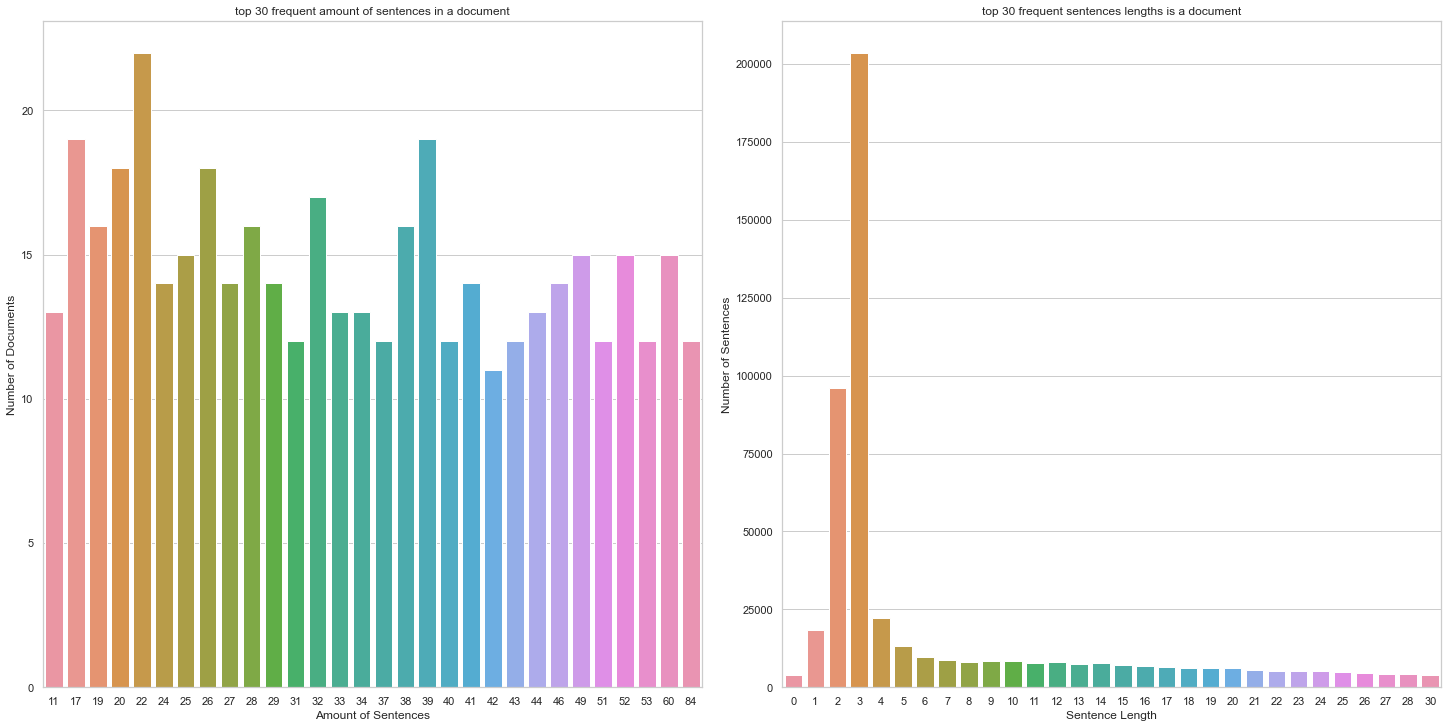

In [27]:
amount_of_sen_counter = Counter(amount_of_sentences_akn)
sen_length_counter = Counter(sentences_lengths_akn)

amount_sen_hist_x, amount_sen_hist_y = get_x_y_from_counter(amount_of_sen_counter)
sen_len_hist_x, sen_len_hist_y = get_x_y_from_counter(sen_length_counter)

fig, axes = plt.subplots(1,2, figsize=(20, 10), constrained_layout=True)

sns.barplot(ax=axes[0], x=amount_sen_hist_x, y=amount_sen_hist_y)
sns.barplot(ax=axes[1], x=sen_len_hist_x, y=sen_len_hist_y)

axes[0].set_title("top 30 frequent amount of sentences in a document")
axes[0].set_xlabel("Amount of Sentences")
axes[0].set_ylabel("Number of Documents")

axes[1].set_title("top 30 frequent sentences lengths is a document")
axes[1].set_xlabel("Sentence Length")
axes[1].set_ylabel("Number of Sentences")

In [28]:
print(f"Mean amount of sentences in a document: {np.mean(amount_of_sentences_akn)}")
print(f"Mean sentence length in a document: {np.mean(sentences_lengths_akn)}")

Mean amount of sentences in a document: 304.55561277033985
Mean sentence length in a document: 12.5811954721102


We can observe several things from the plots:

1. There are a-lot of documents with various amount of sentences. We can see in the plot that for all the values we got the amount is around 20, however, the mean is 304. This means that the plot is not telling us enough about the amount of sentences.

2. There are significantly more sentences with legth of 3 than all the others. This may be because the title of each law is containing about 3 words. The mean is 12 which is quite expected from the plot we got. We can see an increase towards 3 and as the sentence length gets larger the amount of sentences with this lengths gets lower.

We may use these insights from the plots in order to do some optimizations for the models we will create.

Another interesting thing to explore is top frequent terms in the dataset.<br>
This will allow us to see if there is any anomalies in the text and if our preprocessing method was decent.<br><br>
We will plot the most 10 frequent unigrams, bigrams and trigrams in the dataset.

In [29]:
def get_top_ngram(corpus, n=1, limit=10):
    """
    Returns the most frequent ngrams in a corpus
    
    Args:
        corpus (list(String)): a list contaning all the text files.
        n (int, default=1): specifies the ngrams range we want to return.
        limit (int, default=10): specifies the amount of terms wished to be returned.
    """
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in tqdm(vec.vocabulary_.items(), desc=f"Getting {n}-grams")]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:limit]

In [30]:
def bidi_text(text, lst=True):
    """
    transforms a text/list of texts to be readable when plotting.
    """
    if lst:
        bidi_lst = [get_display(v) for v in text]
        return bidi_lst
    else:
        return get_display(text)  

Getting 3-grams: 100%|██████████| 3220051/3220051 [00:02<00:00, 1152998.60it/s]


Text(0, 0.5, 'Ngrams')

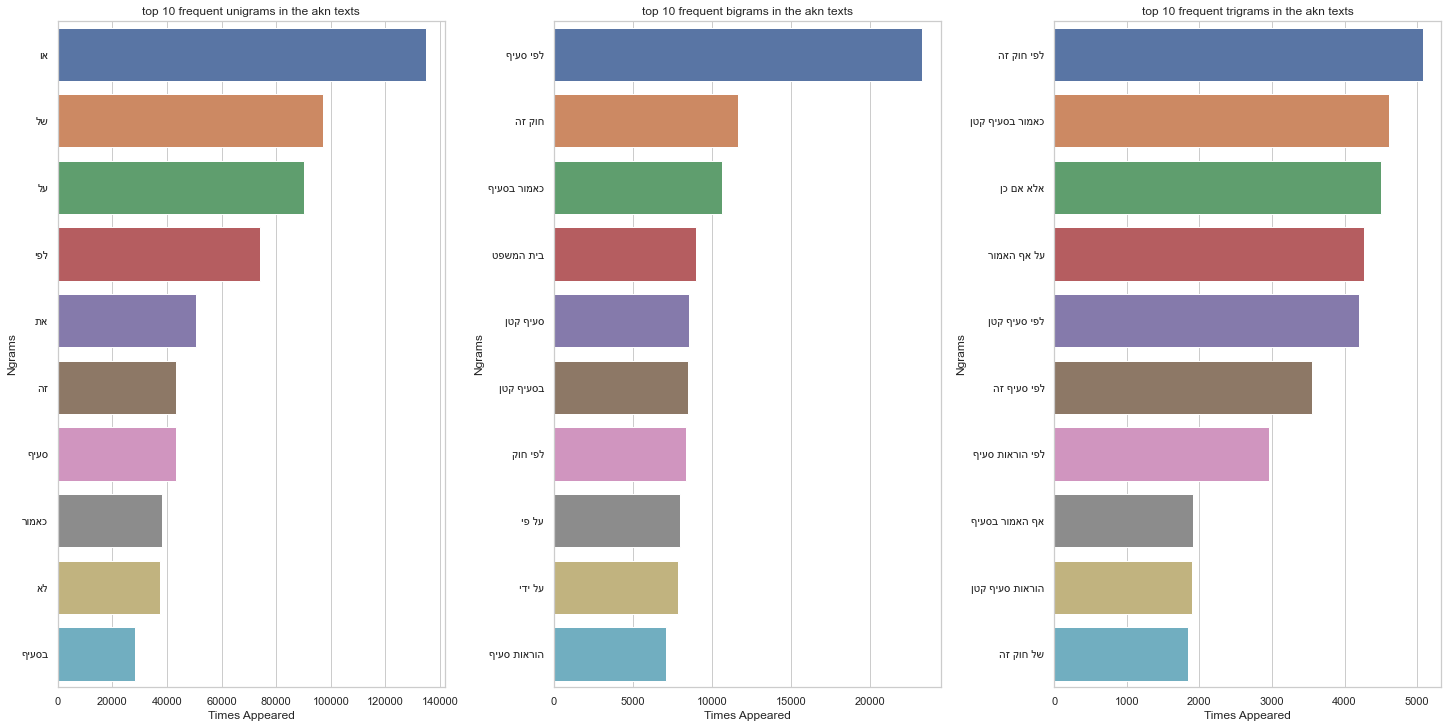

In [31]:
text_col = laws_akn_text_clean["law_akn_text"]

top_10_unigrams = get_top_ngram(text_col, n=1)
top_10_bigrams = get_top_ngram(text_col, n=2)
top_10_trigrams = get_top_ngram(text_col, n=3)

unigrams_10_x, unigrams_10_y = map(list, zip(*top_10_unigrams))
bigrams_10_x, bigrams_10_y = map(list, zip(*top_10_bigrams))
trigrams_10_x, trigrams_10_y = map(list, zip(*top_10_trigrams))

fig, axes = plt.subplots(1,3, figsize=(20, 10), constrained_layout=True)

sns.barplot(ax=axes[0], x=unigrams_10_y, y=bidi_text(unigrams_10_x))
sns.barplot(ax=axes[1], x=bigrams_10_y, y=bidi_text(bigrams_10_x))
sns.barplot(ax=axes[2], x=trigrams_10_y, y=bidi_text(trigrams_10_x))

xlabel = "Times Appeared"
ylabel = "Ngrams"

axes[0].set_title("top 10 frequent unigrams in the akn texts")
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)

axes[1].set_title("top 10 frequent bigrams in the akn texts")
axes[1].set_xlabel(xlabel)
axes[1].set_ylabel(ylabel)

axes[2].set_title("top 10 frequent trigrams in the akn texts")
axes[2].set_xlabel(xlabel)
axes[2].set_ylabel(ylabel)

First, from the plots above we can see that the most frequent terms containing stopwords.<br>
Most of the time it is a good idea to remove these stopwords while doing NLP tasks, in our situation this is not the case.<br>
Since our goal is to detect errors after OCR conversion stopwords are considered as any other words, we need to errors in them also.<br>
Secondly, we can see that as the ngram_range gets larger we can obtain more knowledge about the text in the dataset. We can see term that a more frequent than other, we can see how they are relating to certain parts of a law document such as: sections, title and instructions.<br><br>
Just for the sake of demostration that these terms are not the only main terms in each law we will present the following WordCloud:<br>
We took the law which we showed earlier (חוק איסור הכחשת השואה) and showed the main terms in it using WordCloud.

In [32]:
def plot_word_cloud(text, title=""):
    from wordcloud import WordCloud
    
    bidi_text = get_display(text)
    font_path = "./fonts/VarelaRound-Regular.ttf"
    wordcloud = WordCloud(font_path=font_path).generate(bidi_text)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [33]:
all_akn_text_clean = laws_akn_text_clean["law_akn_text"].values
all_akn_text_clean_concat = " ".join(all_akn_text_clean)

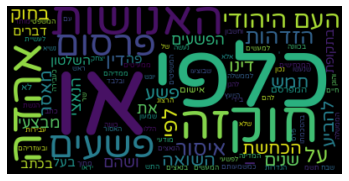

In [34]:
plot_word_cloud(all_akn_text_clean[50])

We can see that although the documents contains a-lot of stopwords, there are a-lot of other frequent terms as well.

### Creating Our Train and Test sets
---
After we cleaned the data it is time to create our train and test set.<br><br>
Let's first understand what is the shape of these sets and from what they are constructed:<br>
Each entry in the sets will be created from a text from the original collected laws that been through damage,<br>we are deliberately damaging the original text and saving it.<br><br>
For each document we will be splitting it to sentences and damage it's content.<br>
Our resulting data will be 3-dimentional, the dimentions are represanted by the following:

1. Num of documents - number of documents taken from the akn files.
2. Num of sentences - for each document the number of sentences it contains.
3. Num of words in a sentence - for each sentence in a document the number of words it contains

Notice that the dimentions 2 and 3 from the list above are not a constant for each document.<br>
We will overcome this obstacle later on when we will try to feed the data to our models.

Before we can create the dataset for the models, let's look at the disribution of real tokens and the erros that appeared in the text.<br>
We went over 300 documents and found the most frequent characters substitutions and erros.

In [35]:
def sort_chars_df(df, by=["Count"], ascending=False):
    """
    Sorting a DataFrame by column.
    """
    df_copy = df.copy()
    df_copy = df_copy.sort_values(by=by, ascending=ascending)
    return df_copy.reset_index(drop=True)

The frequent errors are given in two files which we will explain about now:

* letters_and_errors.csv - characters substitutions and counts that do not contain special characters (such as "," for example).

* letters_and_erros_special_chars.csv - characters substitutions and counts that contain special characters.

In [36]:
letters_and_errors_special_path = "./letters_and_erros_special_chars.csv"
letters_and_errors_special = pd.read_csv(letters_and_errors_special_path)

In [37]:
letters_and_errors_path = "./letters_and_errors.csv"
letters_and_errors = pd.read_csv(letters_and_errors_path)

In [38]:
# sorting the dataframe by "Count" column
letters_and_errors_special = sort_chars_df(letters_and_errors_special)
letters_and_errors = sort_chars_df(letters_and_errors)

In [39]:
def get_replace_chars_labels_and_count(df):
    """
    Returns a list of tuples with the following entries:
        * tuple[0] (String): a string represanting characters substition.
        * tuple[1] (int): represanting the amount the characters substition occured in the text files.
    """
    rep_chars_and_counts = []
    
    for _, row in df.iterrows():
        replace_str = f'{row["Real"]} => {row["Error"]}'
        count = row["Count"]
        rep_chars_and_counts.append((replace_str, count))
    return rep_chars_and_counts

Text(0, 0.5, 'Real to Error')

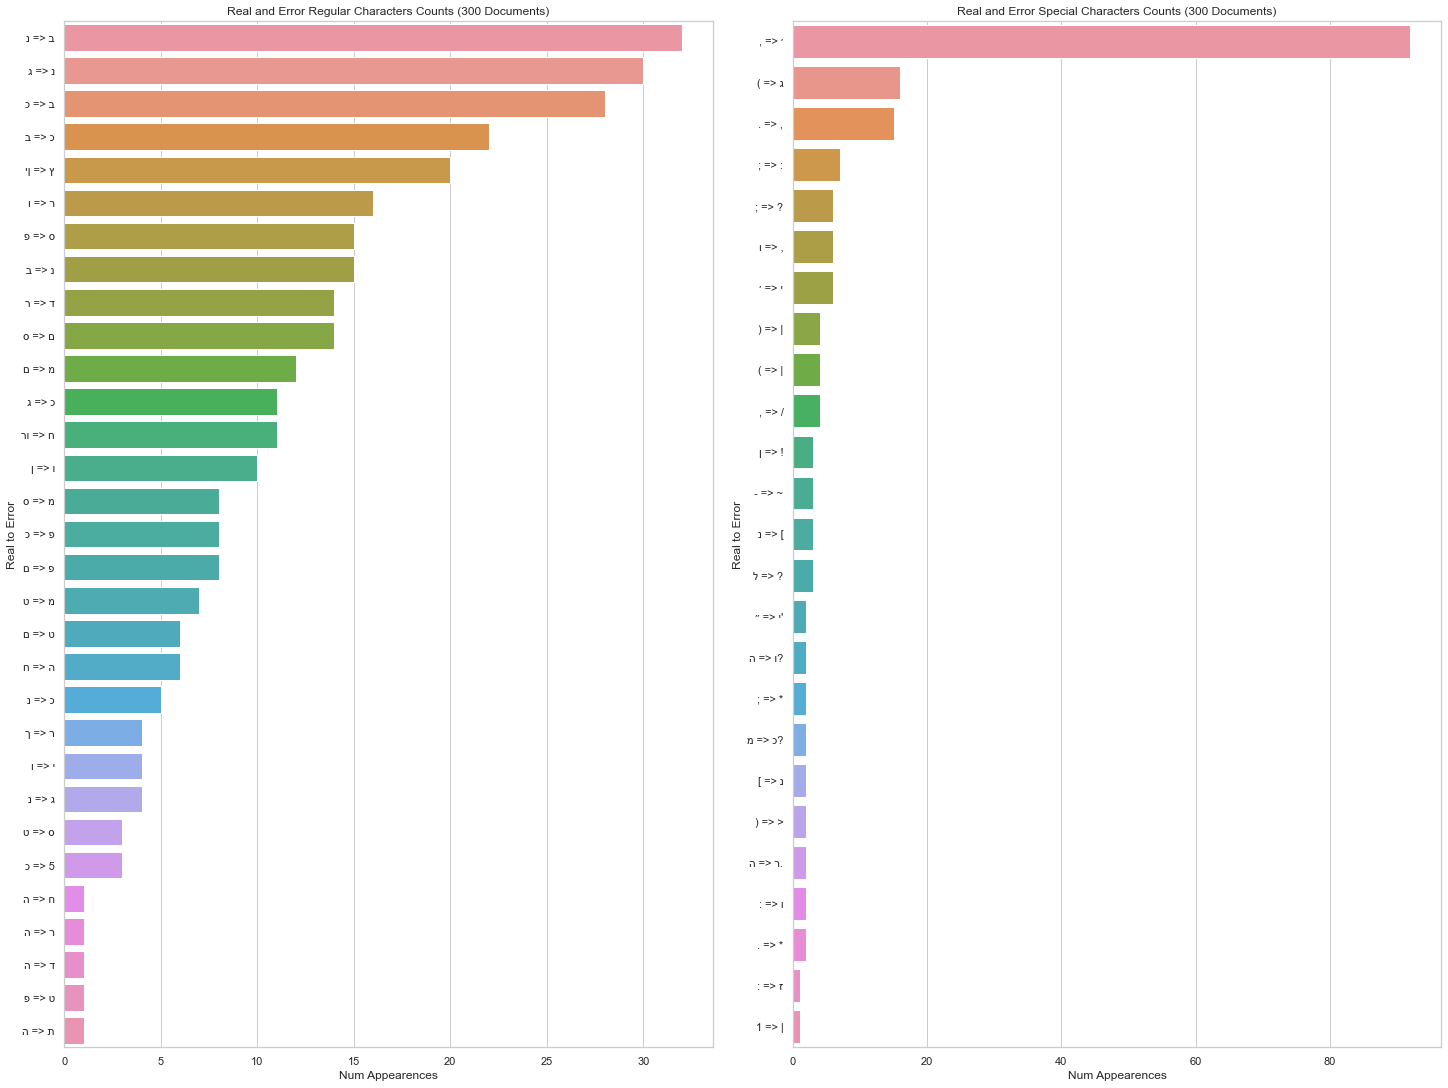

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15), constrained_layout=True)

labels_rep_reg = list(map(lambda x: x[0], get_replace_chars_labels_and_count(letters_and_errors)))
rep_reg_count = list(map(lambda x: x[1], get_replace_chars_labels_and_count(letters_and_errors)))

labels_rep_spe = list(map(lambda x: x[0], get_replace_chars_labels_and_count(letters_and_errors_special)))
rep_spe_count = list(map(lambda x: x[1], get_replace_chars_labels_and_count(letters_and_errors_special)))

sns.barplot(ax=axes[0], x=rep_reg_count, y=labels_rep_reg)
sns.barplot(ax=axes[1], x=rep_spe_count, y=labels_rep_spe)

xlabel = "Num Appearences"
ylabel = "Real to Error"

axes[0].set_title("Real and Error Regular Characters Counts (300 Documents)")
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)

axes[1].set_title("Real and Error Special Characters Counts (300 Documents)")
axes[1].set_xlabel(xlabel)
axes[1].set_ylabel(ylabel)

We can see from the plots that some characters substitions appearned a significant amount of time more than others.<br>
Later on we will consider of which characters it is best to take in order to get the best results in the models.

#### Damaging original text
---
Now it is time to damaged the dataframes text using the given csv files.<br>
We will guassian distribution in order to damage the text. Each time we will sample a common error from the dicitionaries we made before and use it to damage the text. We will then mark the index of the token we damaged in a sentence as 1. The result is a binary matrix, where 1 indicates a damaged word and 0 non-damaged.

In [41]:
def create_list_for_counts(df, real="Real", error="Error"):
    lst_real = []
    lst_error = []
    real_error_dict = {}
    for i, row in df.iterrows():
        lst_real.append(str(row["Real"]))
        
        real_error_dict[str(row["Real"])] = str(row["Error"])
        
    return lst_real, real_error_dict

In [42]:
def damage_text_files_new(text, token_damage_df, special_token_damage_df, max_sent_len=50, damage_ratio_text=0.2):
    """
    Creates damage in the laws content. The damage based on guassian distribution of the data
    frame that contains real tokens and their errors.
    We can set the ratio of how many percentage of the text we want to damage.
    The damaging is done randomly in the text.
    
    Args:
        text: law content
        token_damage_df: Data frame of the letter tokens and their errors
        special_token_damage_df: Data frame of the special tokens and their errors.
        max_sent_len: can define the maximum sentence length.
        damage_ratio_text: Sets what is the percetange of the text that will be damaged.
        
    Returns:
        1. text after it has been damaged.
        2. ground truth matrix for the text, it is binary matrix. 1 indicate a word/token that
        was damaged and 0 word/token that was not damaged.
    
    """   
    # create list for special and regular tokens
    lst_reg_real_token, real_error_dict_reg = create_list_for_counts(token_damage_df)
    lst_special_real_token, real_error_dict_special = create_list_for_counts(special_token_damage_df)
    
    all_words_len = len(nltk.word_tokenize(text))
    sentences = text.split("\n")
    damage_words_sentences_indexes = np.zeros((len(sentences), max_sent_len))
    
    # total amount of damage for special and regular token
    total_damage_reg_token = int(damage_ratio_text * all_words_len * 0.8)
    total_damage_special_token = int(damage_ratio_text * all_words_len * 0.2)
    
    # create distribution for each token and number of time to damage
    reg_dict = Counter(lst_reg_real_token[int(random.betavariate(1.3, 5)*len(lst_reg_real_token))] for _ in range(total_damage_reg_token))
    special_dict =Counter(lst_special_real_token[int(random.betavariate(0.1, 5)*len(lst_special_real_token))] for _ in range(total_damage_special_token))
    
    for i, token_real in enumerate(reg_dict):

        for j in range(reg_dict[token_real]):
            
            # take random sentence
            sent_idx = random.randint(0, len(sentences) -1)
            sent = sentences[sent_idx]
            sent = " ".join(sent.split())
            words = sent.split()

            # Check in which words the charcter appear in
            word_char_occur = []
            for j, word in enumerate(words):
                if token_real in word and j < max_sent_len:
                    word_char_occur.append(j)
            
            # if there is no appearnce, concatanate the sentence and continue the next loop
            if word_char_occur == []:
                sent = ' '.join(words)
                sentences[sent_idx] = sent
                continue
            
            # if there are appearances, take random word, 
            word_idx = random.randint(0, len(word_char_occur) -1)
            word_idx = word_char_occur[word_idx]
            if damage_words_sentences_indexes[sent_idx][word_idx] == 0:
                word = words[word_idx]
                if len(token_real) == 2:
                    new_word = word.replace(token_real, real_error_dict_reg[token_real])
                    words[word_idx] = new_word
                    damage_words_sentences_indexes[sent_idx][word_idx] = 1
                else:
                    first_occur = word.find(token_real)
                    word = list(word)
                    word[first_occur] = real_error_dict_reg[token_real]
                    word = ''.join(word)
                    words[word_idx] = word
                    damage_words_sentences_indexes[sent_idx][word_idx] = 1

            sent = " ".join(words)
            sentences[sent_idx] = sent
            
    for i, token_special in enumerate(special_dict):
        
        for j in range(special_dict[token_special]):
            
            # take random sentence
            sent_idx = random.randint(0, len(sentences) -1)
            sent = sentences[sent_idx]
            sent = " ".join(sent.split())
            words = sent.split()
            
            # Check in which words the charcter appear in
            word_char_occur = []
            for j, word in enumerate(words):
                if token_special in word and j < max_sent_len:
                    word_char_occur.append(j)
            
            # if there is no appearnce, concatanate the sentence and continue the next loop
            if word_char_occur == []:
                sent = ' '.join(words)
                sentences[sent_idx] = sent
                continue
            
            # if there are appearances, take random word, 
            word_idx = random.randint(0, len(word_char_occur) -1)
            word_idx = word_char_occur[word_idx]
            if damage_words_sentences_indexes[sent_idx][word_idx] == 0:
                word = words[word_idx]
                first_occur = word.find(token_special)
                word = list(word)
                word[first_occur] = real_error_dict_special[token_special]
                word = ''.join(word)
                words[word_idx] = word
                damage_words_sentences_indexes[sent_idx][word_idx] = 1

            sent = " ".join(words)
            sentences[sent_idx] = sent

    text = '\n'.join(sentences)
    return text, damage_words_sentences_indexes

In [43]:
def shuffle_df(df):
    """
    shuffles a DataFrame randomly.
    """
    from sklearn.utils import shuffle
    df = shuffle(df)
    return df

In [44]:
def create_damaged_df_and_label(df, rand_df, damage_df, damage_df_special, text_col_name="law_akn_text"):
    df_damage_lst = []
    
    for i, row in tqdm(df.iterrows(), desc="Damaging akn text"):
        damaged_text, damaged_words_sen = damage_text_files_new(row[text_col_name], damage_df, damage_df_special)
        df_damage_lst.append({
            "law_id": row["law_id"],
            "damaged_text": damaged_text,
            "damaged_words_sen": damaged_words_sen,
        })
    
    for i, row in tqdm(rand_df.iterrows(), desc="Damaging scraped laws text"):
        damaged_text, damaged_words_sen = damage_text_files_new(row["law_text"], damage_df, damage_df_special)
        df_damage_lst.append({
            "law_id": i,
            "damaged_text": damaged_text,
            "damaged_words_sen": damaged_words_sen,
        })
    col_names = ["law_id", "damaged_text", "damaged_words_sen"]
    return pd.DataFrame(df_damage_lst, columns=col_names)

In [45]:
akn_df = laws_akn_text_clean
rand_df = random_laws_text_clean
damaged_df = create_damaged_df_and_label(akn_df, rand_df, letters_and_errors, letters_and_errors_special)
random.seed(42)

Damaging akn text: 1942it [00:47, 40.58it/s] 
Damaging scraped laws text: 1993it [01:00, 32.91it/s]


In [46]:
damaged_df

,law_id,damaged_text,damaged_words_sen
0,2002137,\nהחוק העותומני על האכודות\nהנוסח מונא בתרכום ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2001743,\nפקודת האגודות השיתופיות\nפקודה המאחדת ומתקגת...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,100009229,\nתקנות האגודות השיתופיות ( אגודות שיתופיות לא...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,100030557,"\nתקנות האגודות השיתופיות ( אגרות ) , התשס״ב –...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100005558,\nתקנות האגודות השיתופיות ( בוררות בסכסוכים ) ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
3930,1988,וק המיעצות האזוריות ( בחירת ראש המיעצה ) מתוך\...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
3931,1989,וק כלי היריה מתוך\nחיק כלי הידיה / תש״ט – 1949...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3932,1990,קנות החברות ( הקלות בעסקאות עם בעלי עגין ) מתו...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."
3933,1991,קודת התאוגות ומחלות משלח - היד ( הידעה ) מתוך\...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."


We can now save the dataframe with the errors for later use

In [47]:
def save_text_damaged_in_file(text, path):
    """
    Saves a damaged text file in path
    
    Args:
        text (String): text to be saved.
        path (String): where to save the text file.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)

def save_ground_truth_in_file(np_matrix, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.save(path, np_matrix)

def save_damaged_text_from_df(df):
    base_file_path = "./Damaged_texts"
    base_file_path_gt = "./ground_truth"
    for i, row in df.iterrows():
        law_id = row["law_id"]
        ground_truth = row["damaged_words_sen"]
        law_damaged_text = row["damaged_text"][1:]
        
        file_path = f'{base_file_path}/{law_id}.txt'
        
        gt_file_path = f'{base_file_path_gt}/{law_id}.npy'
        
        save_text_damaged_in_file(law_damaged_text, file_path)
        
        save_ground_truth_in_file(ground_truth, gt_file_path)

In [48]:
save_damaged_text_from_df(damaged_df)

In [49]:
directory = "./Damaged_texts/"
df_damage_lst = []
for filename in os.listdir(directory):
    file = open(directory + filename, "r", encoding="utf-8")
    damaged_text = file.read()
    filename = filename[:-4]
    df_damage_lst.append({
        "law_id": filename,
        "damaged_text": damaged_text,
    })
col_names = ["law_id", "damaged_text"]
damaged_df_v1 = pd.DataFrame(df_damage_lst, columns=col_names)


In [50]:
directory = "./ground_truth/"
df_damage_lst = []
for i, filename in enumerate(os.listdir(directory)):
    mat = np.load(directory + filename)
    mat = mat[1:]
    filename = filename[:-4]
    df_damage_lst.append({
        "law_id": filename,
        "damaged_text": damaged_df_v1["damaged_text"][i],
        "damaged_words_sen": mat,
    })
col_names = ["law_id", "damaged_text", "damaged_words_sen"]
damaged_df = pd.DataFrame(df_damage_lst, columns=col_names)

In [51]:
damaged_df = shuffle_df(damaged_df)

Now it is time to split the data for train, test and validation<br>
Since we want the model to learn on a large amount of data we will be using the following train,test,validation split:

1. 70% of the data will be for train.
2. 20% of the data will be for validation.
3. 10% of the data will be for test.

In [52]:
X_train = damaged_df["damaged_text"][1180:]
y_train = damaged_df["damaged_words_sen"][1180:]

from sklearn.model_selection import train_test_split

X_test, X_validation, y_test, y_validation = train_test_split(damaged_df["damaged_text"][:1180], damaged_df["damaged_words_sen"][:1180], test_size=0.66, random_state=24)

##### Creating a tokenizer
---
The next step is to transform our data to sequences, in order to do so we will use keras built in Tokenizer.<br>
The text we will be feeding the tokenizer with will be constructed from the following:

* all the text from the train set.
* all the years, days and months including prefixes.
* all numbers between 0-5000

In [53]:
def get_numbers_to_tokenizer():
    number_strings = ""
    for i in range(5000):
        number_strings += " " + str(i) + " "
    return number_strings

In [54]:
# joining all the text in the train set

all_text = " ".join(akn_df["law_akn_text"][1180:])

all_text_rand = " ".join(rand_df["law_text"])

day_string = " ".join(days_list_pref)

years_string = " ".join(years_list)

month_string = " ".join(month_list_pref)

all_train_text = " ".join([all_text, all_text_rand, get_numbers_to_tokenizer(), day_string, years_string, month_string])

In [55]:
sentence_length = 50
epochs = 25
batch_size = 200

In [56]:
def generate_tokenizer(train_txt):
    """
    Args: 
         train_txt (String) - All the data in one text file, for the tokenizer
    Returns: 
        vocab_size (int) - the size of vocabulary that was created by the tokenizer
        tokenizer (keras.Tokenizer) - in order to use for all the texts with the same tokens
    """
    tokenizer_ = Tokenizer(filters='\t\n', oov_token='unk')
    tokenizer_.fit_on_texts([train_txt])
    vocab_size = len(tokenizer_.word_index) + 1
    train_db = tokenizer_.texts_to_sequences([train_txt])[0]

    return tokenizer_, vocab_size, train_db

In [57]:
tokenizer, vocab_size, train_db = generate_tokenizer(all_train_text)

In [58]:
vocab_size

137422

###### Creating X sets
---
In order to use machine learning models and also deep learning the data needs to be coverted to constant shape.<br><br>
We will first describe the transformation on the X sets:<br><br>
As recalled, the X sets containing the damaged text for each document. In order to transform it constant size we will decide on a constant **amount of sentences** and **constant sentence length**. So, for each document we will taking a constant amount of sentences and each sentence will be at a constant length.
In order to feed the data to the models we need to transofrm it to numbers. We will use the generated tokenizer from above in order to transfom each sentence in a doucment to a sequence of numbers.<br><br>
So the final shape for the X sets will be: (Num of Documents, Number of Sentences, Sentence Length).

###### Creating Y sets
---
Next, we will describe the transformation on the Y sets:<br><br>
As recalled, the Y sets containing a 2d matrix for each document. Each row in the matrix represant a sentence in the document and each column represant the terms in the sentence. The transformation of these sets will be quite the same as the one for the X sets. We will take a constant amount of sentences and a constant sentence length as the ones before.<br><br>
So the final shape for the y sets will be: (Num of Documents, Number of Sentences, Sentence Length).
<br><br>

**Note**: We took the following parameters based on the means we calculated above:
* amount of sentences in a document - 200 (mean is about 305).
* sentence length - 50 (mean is about 13).

In [59]:
def create_X_set(lines, tokenizer):
    """
    transform @lines to sequences given by @tokenizer.
    
    Args:
        lines (list(String)): list of lines composing a text file.
        tokenizer (keras.Tokenizer): a keras tokenizer trained on text.
    """
    lines_tokens = np.zeros((batch_size, sentence_length))
    
    for i, line in enumerate(lines):
        # taking only the first @batch_size lines
        if i < batch_size:
            line_seq = tokenizer.texts_to_sequences([line])
            # pad each sequence with 0 to reach @sentence_length
            line_seq = pad_sequences(line_seq, maxlen=sentence_length, padding='post')
            lines_tokens[i] = line_seq[0]
    
    return np.array([lines_tokens])

def create_y_set(damage_matrix):
    damaged_mat = np.zeros((batch_size, sentence_length))
    
    for i, sen_damage_mat in enumerate(damage_matrix):
        # taking only the first @batch_size matrices
        if i < batch_size:
            # pad each sequence with 0 to reach @sentence_length
            curr_damage = pad_sequences([sen_damage_mat], maxlen=sentence_length, padding='post')
            damaged_mat[i] = curr_damage
    
    return np.array([damaged_mat])

def create_X_and_y_set(text_lines, tokenizer, label):
    X = create_X_set(text_lines, tokenizer)
    y = create_y_set(label)
    return X, y      

In [60]:
def create_models_sets(texts, labels, tokenizer):
    """
    Creating train sequences and labels in a constant shape.
    
    Args:
        texts (list(String)): all the texts files.
        labels (list(numpy.array)): damaged matrices labels for all the documents.
        tokenizer (keras.Tokenizer): a keras tokenizer trained on text.
    """
    texts_and_labels = list(zip(texts[1:], labels[1:]))
    X, y = create_X_and_y_set(texts[0].split("\n"), tokenizer, labels[0])
    
    for text, label in tqdm(texts_and_labels, desc="Creating train/test sets"):
        curr_X, curr_y = create_X_and_y_set(text.split("\n"), tokenizer, label)
        X = np.vstack((X, curr_X))
        y = np.vstack((y, curr_y))
    return X, y

In [61]:
# converting the train set to constant shapes
X_train_v1, y_train_v1 = create_models_sets(X_train.values, y_train.values, tokenizer)

Creating train/test sets: 100%|██████████| 2754/2754 [04:33<00:00, 10.08it/s]


In [62]:
# converting the test set to constant shapes
X_test_v1, y_test_v1 = create_models_sets(X_test.values, y_train.values, tokenizer)

Creating train/test sets: 100%|██████████| 400/400 [00:06<00:00, 58.79it/s] 


In [63]:
# converting the validation set to constant shapes
X_validation_v1, y_validation_v1 = create_models_sets(X_validation.values, y_validation.values, tokenizer)

Creating train/test sets: 100%|██████████| 778/778 [00:23<00:00, 32.88it/s] 


#### Machine Learning Models
---

Next, we will use the following Machine Learning algorithms:

1. RandomForestClassifier
2. MLPClassifier
3. DecisionTreeClassifier

We will use the Machine-Learning models described above and do 5-cross-validation. In order to do hyperparameter tuning we will use GridSearchCV.

GridSeachCV allows us to perform cross-validation while running the models with different parameters. The GridSeachCV saves the model with the best score under an attribute called bestestimator .

Although GridSearch sounds like a good idea it may take a long time to run, since we are checking every possible combination. Sometimes it is better to use RandomizedSearchCV which selects a fraction of the possible combinations.

We chose a sample of parameters for the models just to get a feeling of the results and metrics. The task of parameter choosing is a difficult one, most of the time you will not know what is the right parameters for a model.

In [64]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'params' : {
            'n_estimators': [100, 200],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 100],
        }  
    },
    'mlp' : {
        'model': MLPClassifier(random_state=42),
        'params': {
            'solver': ['sgd', 'adam'],
            'activation': ['logistic', 'relu'],
        }
    },
    'decision_tree' : {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 100],
        }
    },
}

In [135]:
# Defining custom socrers for ML models

def check_accuracy(y_true, y_pred):
    correct = y_true == y_pred
    denom = (correct.shape[0] * correct.shape[1]) if len(correct.shape) > 1 else correct.shape[0]
    return float(correct.sum()) / denom

def check_accuracy_round(y_true, y_pred):
    return check_accuracy(y_true, y_pred.round())

def check_precision_ml(y_true, y_pred):
    y_pred_round = y_pred.round()
    return precision_score(y_true.reshape(-1), y_pred_round.reshape(-1), pos_label=1)

def check_recall_ml(y_true, y_pred):
    y_pred_round = y_pred.round()
    return recall_score(y_true.reshape(-1), y_pred_round.reshape(-1), pos_label=1)

In [130]:
def get_metrics_df(y_true, y_pred):
    scores = []
    scores.append({
        "accuracy": check_accuracy_round(y_true, y_pred),
        "precision": check_precision_ml(y_true, y_pred),
        "recall": check_recall_ml(y_true, y_pred)
    })
    
    return pd.DataFrame(scores, columns=["accuracy", "precision", "recall"])

In [66]:
def get_models_and_scores(X_train, y_train, cv=3):
    """
    Train different models based on different parameters on a train set.
    
    Args:
        X_train (np.array): train set features the models train upon.
        y_train (np.array): labels for the train set that the models train upon.
        cv (int, default=3): cross-validation count.
    
    Returns:
        1. The models that were trained in the function.
        2. Scores and metrics given by the training process
        3. Scores and metric in a form of a DataFrame.
    """
    # saving each model scores in a list
    scores = []
    # saving each model in a list
    models = []
    # scores metrics for each model
    scorers = {
        'Accuracy': make_scorer(check_accuracy_round),
        'Precision': make_scorer(check_precision_ml),
        'Recall': make_scorer(check_recall_ml),
    }

    for model_name, mp in model_params.items():
        # doing cross-validation GridSearch on each model
        clf = GridSearchCV(mp['model'], mp['params'], scoring=scorers,refit="Accuracy", cv=cv, n_jobs=-1, verbose=1)
        clf.fit(X_train, y_train)
        models.append(clf)
        scores.append({
            'model': model_name,
            'best_accuracy': clf.best_score_,
            'mean_precision': np.mean(clf.cv_results_["mean_test_Precision"]),
            'mean_recall': np.mean(clf.cv_results_["mean_test_Recall"]),
            'best_params': clf.best_params_,
        })
    # creating a DataFrame with the result  
    scores_df = pd.DataFrame(scores,columns=['model','best_accuracy','mean_precision','mean_recall','best_params'])  
    return models, scores, scores_df

We will reshape the sets to 2d array, the rows will act as sentences and the columns as the terms in the sentences.<br>So all the sentences from all the documents will be stacked on each other.<br>
So after reshaping the classification task acts like multi-label classification task, where each class is a term in a sentence.

In [67]:
X_train_v1_re = X_train_v1.reshape((-1, sentence_length))
y_train_v1_re = y_train_v1.reshape((-1, sentence_length))

X_validation_v1_re = X_validation_v1.reshape((-1, sentence_length))
y_validation_v1_re = y_validation_v1.reshape((-1, sentence_length))

X_test_v1_re = X_test_v1.reshape((-1, sentence_length))
y_test_v1_re = y_test_v1.reshape((-1, sentence_length))

In [68]:
models_train_v1, scores_train_v1, scores_train_df_v1 = get_models_and_scores(X_train_v1_re, y_train_v1_re)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.8s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/roylevy/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished


In [69]:
scores_train_df_v1

,model,best_accuracy,mean_precision,mean_recall,best_params
0,random_forest,0.994843,0.00000,0.000000,"{'criterion': 'entropy', 'max_depth': None, 'n..."
1,mlp,0.994843,0.00439,0.027083,"{'activation': 'logistic', 'solver': 'sgd'}"
2,decision_tree,0.989477,0.00000,0.000000,"{'criterion': 'entropy', 'max_depth': None}"


In [70]:
best_model_v1 = models_train_v1[0].best_estimator_
model_name = scores_train_df_v1["model"][0]
preds_v1 = best_model_v1.predict(X_test_v1_re)

In [71]:
print(f"Classification Report for {model_name} - Test Set")
print(classification_report(y_test_v1_re.reshape(-1), preds_v1.reshape(-1)))

Classification Report for random_forest - Test Set
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   3947824
         1.0       0.19      0.00      0.00     62176

    accuracy                           0.98   4010000
   macro avg       0.59      0.50      0.50   4010000
weighted avg       0.97      0.98      0.98   4010000



In [72]:
preds_v1_val = best_model_v1.predict(X_validation_v1_re)
print(f"Classification Report for {model_name} - Validation Set")
print(classification_report(y_validation_v1_re.reshape(-1), preds_v1_val.reshape(-1)))

Classification Report for random_forest - Validation Set
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   7669070
         1.0       0.09      0.00      0.00    120930

    accuracy                           0.98   7790000
   macro avg       0.54      0.50      0.50   7790000
weighted avg       0.97      0.98      0.98   7790000



Our best ML model is RandomForrest.<br>
As we can see from the classfications reports and the scores dataframe, the model performed very well on the labels that contained 0 but not so well on the labels that contained 1, this means that the model is not classifying most of the errors.<br>
We were able to notice this due to the use of **precision** & **recall**.<br>
We can see that the **accuracy score** is not indicative since our classes are unbalanced (most of the labels are 0).<br><br>
In order to increase our precision and recall we will create a better model using Deep Learning techniques.

#### Deep Learning Model
---
By now we saw that the simple Machine Learning models are not able to detect the erros in the text so we need to use some "bigger guns".<br>
We will create a quite simple **RNN** using **Word Embeddings**. This network architecture will allow the model to understand the semantic meaning (context) between the terms in the text. Understanding the context is crushial in order to detect what word contains an error and what word isn't.<br><br>

In the following sections we will explain and review the steps we have made in order to reach better results.

###### Metrics & Callbacks
---
As we saw before, **accuracy** is not a good metric when the classes are imbalanced. Since our data contains mostly zeros it is good to use another types of metrics. We've decided to **precision** and **recall** as our main metrics in order to evaluate the model during the training phase, we also monitered the **confusion matrix**(TP, TN, FP, FN).<br><br>
In order to monitor these metrics at each phase we had to define a **custom callback**: at each end of epoch we will calculate and print the relavant metrics to the screen.

In [73]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))
        mat = confusion_matrix(np.squeeze(y_val).reshape(-1), np.squeeze(y_predict.round()).reshape(-1))
        perc=(mat[1][1])/(mat[1][1]+mat[0][1] + 0.00001)
        reco=(mat[1][1])/(mat[1][1]+mat[1][0] + 0.00001)
        print(f"percision_bar = {float(perc)}")
        print(f"recall_bar = {float(reco)}")
        print(f"True positive = {mat[1][1]}")
        print(f"True negative = {mat[0][0]}")
        print(f"False positive = {mat[0][1]}")
        print(f"False negative = {mat[1][0]}")

    def get_data(self):
        return self._data

We defined the following callbacks in order to further our monitoring during the training phase, this allowed us to gain a better understanding on how the model behaves and optimize it.<br>
The callbacks we defined are the following:

1. **Model Checkpoint** - allow us to save the best weights of the model so we don't have retrain again (the training process takes a long time).
2. **EarlyStopping** - stops training the model the validation loss not decreasing after certain amount of ephocs (save us time in the training process).
3. **ReduceLROnPlateau** - reduces the learning rate when we reach local minimum, tries to find the global minimum so the network converges.
4. **Metrics** - our custom metrics callback we defined earlier.

In [74]:
checkpoint = ModelCheckpoint("./models/try1"+"_weights.{epoch:02d}-{val_loss:.5f}.hdf5",save_best_only=False,monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss' ,patience=5, restore_best_weights=False, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_delta=0.001, mode='min', min_lr=1e-6)
metrics_bar = Metrics()

callbacks = [earlystopping, reduce_lr, checkpoint, metrics_bar]

###### Loss Function
---
In order that our network will truly learn we must define a proper loss function, so the network can adjust the weights at each end of an epoch. After examining various types of built in loss functions we have decided to create a **custom loss function** because the other ones not gave us exactly what we seached for.<br><br>
We decided to go with a modification of the loss function **binary crossentropy** by adding a custom weight to the function.<br>
The idea is that the loss function will "punish" the network by a cetrain weight if the prediction is not correct (if the false-positive/false-negative as occured).

In [75]:
def weighted_binary_crossentropy_v1(w1, w2):
    def loss(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        logloss = -(y_true * K.log(y_pred) * w1 + (1 - y_true) * K.log(1 - y_pred) * w2 )
        return K.mean( logloss, axis=-1)

    return loss

In [76]:
# hyperparameters for the model
hidden_size = 100
units_lstm = 125
units_lstm_1 = 25

Finally we can define our network, a quite simple RNN which consist mainly on WordEmbedding and LSTM. Notice how gave the last layer the activation function **sigmoid** this tells the network that each entry in the predicted vectors can be values between 0 to 1 (we will round these values later).

In [77]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=hidden_size, input_length=sentence_length, trainable=False))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1, activation="sigmoid")))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           13742200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 125)           113000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 125)           125500    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 125)           125500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 125)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 1)             126       
Total params: 14,106,326
Trainable params: 364,126
Non-trainable params: 13,742,200
____________________________________

In [78]:
# defining an optimizer
opt = Nadam(learning_rate=0.01)

In [220]:
# compiling the model
model.compile(opt, loss=weighted_binary_crossentropy_v1(3, 1), metrics=["accuracy"])

In [79]:
# reshaping the lables
shaped_y_train_v1_re = np.expand_dims(y_train_v1_re, axis=2)
shaped_y_validation_v1_re = np.expand_dims(y_validation_v1_re, axis=2)

In [223]:
# training the model
model.fit(x=X_train_v1_re, y=shaped_y_train_v1_re, validation_data=(X_validation_v1_re, shaped_y_validation_v1_re), batch_size=128, epochs=25, callbacks=callbacks)

Train on 551000 samples, validate on 155800 samples
Epoch 1/25
551000/551000 [==============================] - 539s 979us/step - loss: 0.0385 - accuracy: 0.9952 - val_loss: 0.0307 - val_accuracy: 0.9961
percision_bar = 0.9109130158827825
recall_bar = 0.8232820607009442
True positive = 97894
True negative = 7661519
False positive = 9574
False negative = 21013
Epoch 2/25
551000/551000 [==============================] - 530s 962us/step - loss: 0.0298 - accuracy: 0.9962 - val_loss: 0.0282 - val_accuracy: 0.9964
percision_bar = 0.9235474290828355
recall_bar = 0.8317340441831235
True positive = 98899
True negative = 7662906
False positive = 8187
False negative = 20008
Epoch 3/25
551000/551000 [==============================] - 531s 963us/step - loss: 0.0279 - accuracy: 0.9963 - val_loss: 0.0275 - val_accuracy: 0.9963
percision_bar = 0.9145883970727274
recall_bar = 0.838579730306998
True positive = 99713
True negative = 7661781
False positive = 9312
False negative = 19194
Epoch 4/25
551000/5

In [82]:
# loading the model from previous weights
model = keras.models.load_model("./models/try1_weights.20-0.02713.hdf5", custom_objects={ 'loss': weighted_binary_crossentropy_v1(3, 1)})

We will take a fraction from the test set because the prediction can take a-lot of time.

In [128]:
y_pred_dl = model.predict(X_test_v1_re[:10000])

In [129]:
print(f"Classification Report for Deep Learning Model - Test Set")
print(classification_report(y_test_v1_re[:10000].reshape(-1), y_pred_dl.round().reshape(-1)))

Classification Report for Deep Learning Model - Test Set
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    491140
         1.0       0.03      0.02      0.03      8860

    accuracy                           0.97    500000
   macro avg       0.51      0.50      0.51    500000
weighted avg       0.97      0.97      0.97    500000



We can see that the precision and the recall are not high as the validation set dictates. This can be because we took a fraction of the test to predict upon. Later on we will see that our model is quite good actually and these results are not proper metric to measure the accuracy.

##### Predicting on DOCX files
---
So now after we trained the model it is time to use it on the DOCX files.<br>
First, we will load all the files into a DataFrame and perform the save preprocessing steps as on the other text files.

In [84]:
def create_docx_df(docx_path):
    """
    Args:
        docx_path - path the the dir where all the docx file located
    
    Return:
        docx_df - This is data frame contains all the docx files texts and their laws id.
    """
    docx_texts = []
    file_names = os.listdir(docx_path)
    
    for file_name in tqdm(file_names, desc="Reading DOCX"):
        law_id = file_name.split(".")[0]
        try:
            law_docx_path = f'{docx_path}/{file_name}'
            law_docx_text = get_law_docx_text(law_docx_path)
            
            docx_texts.append({
                "law_id": law_id,
                "law_docx_text": law_docx_text,
            })
        except Exception as e:
            pass
        
    law_docx_df = pd.DataFrame(docx_texts, columns=["law_id", "law_docx_text"])
    return law_docx_df

In [85]:
# creating a dataframe from DOCX files
docx_df = create_docx_df(docx_path)

Reading DOCX: 100%|██████████| 3888/3888 [00:21<00:00, 182.00it/s]


In [86]:
# preprocessing the DOCX files
law_docx_df_clean = preprocess_text(docx_df, text_column_name="law_docx_text")

In [87]:
print(law_docx_df_clean["law_docx_text"][0])

01 ספר החוקים 207 כ״ו באב התשי״ו 03 . 08 . 1956
* נתקבל בכנסת ביום י״ז באב תשט״ז ( 25 ביולי 1956 ) ; הצעת החוק ודברי הסבר נתפרסמו
בה״ח 278 , תשט״ז , עמ׳ 163 .
1 ס״ח ת190 , תשט״ו עמ׳ 242 .
לוי אשכול
שר האוצר
דוד בן - גוריון
ראש הממשלה
יצחק בן - צבי
נשיא המדינה
תיקון החוק
1 . בסעיף 1 לחוק בנק ישראל ( הוראת שעה ) ׳ תשט״ו - 1955 1 , במקום ״ כ ״ ו באב תשט״ז
0 : באוגוסט 1956 ) ״ יבוא ״ ב׳ באדר א׳ תשי״ז ( 3 בפברואר 1957 ) ״ .
מספר 59
חוק בנק ישראל ( הוראת שעה ) ( תיקון מס׳ 2 ) , תשט״ז - 1956 *


The next step is to transform the data into a proper shape in order to feed to our model.<br>
We will note that a document can contain more than 200 sentences, which is the maximun amount of sentences we defined earlier for a document. Since we will to predict on all the data a document can span on more than one batches. For example: let's say we have a document with 300 sentences, it will span on 2 batches at a length of 200 (the other sentences will be padded). Our job is also to map the batches back to the relevant files.

In [88]:
def create_batch_size_matrices(docx_law_to_lines, tokenizer):
    """
    Args: 
        docx_law_to_lines - The law text file splited into lines
        tokenizer - Use to convert the text file words to tokens (with the same dictionary)

    Return: 
        X - Array of matrices which each matrix is in the size of (batch_size, sentence_length)
    """

    text_len = len(docx_law_to_lines)
    index = 0

    X = []

    while True:
        if text_len > batch_size:
            mat = create_batch_matrix_X(docx_law_to_lines[batch_size * index:batch_size * (index + 1)], tokenizer)
            X.append(mat)
            text_len -= batch_size
            index += 1
        else:
            mat = create_batch_matrix_X(docx_law_to_lines[batch_size * index:len(docx_law_to_lines)], tokenizer)
            X.append(mat)
            break

    return np.array(X)

In [89]:
"""
    params: 
         text - the text of the file
         tokenizer - Use to tokenize each sentence.
    return: 
        return matrix X of (batch_size, sentence_length) with padding to the sentences.
"""
def create_batch_matrix_X(text, tokenizer):
    mat_x = np.zeros((batch_size, sentence_length))

    for i, line in enumerate(text):
        line = re.sub('\t\n', '', line)
        line_seq = tokenizer.texts_to_sequences([line])
        line_seq = pad_sequences(line_seq, maxlen=sentence_length, padding='post')
        mat_x[i] = np.array(line_seq[0], dtype=int)

    return mat_x

In [90]:
def prepare_data_to_predict(docx_df):
    """
    Args:
        docx_df - docx data frame, contains all the docx texts.
    
    Return:
        docx_files_num_of_batches - list of all the docx text file number of batchs to each text.
        Each text can be splited into more than one batch size.
        docx_batch_matrices - list of all texts files splited into batch size matrices.
    """
    docx_files_num_of_batches = []
    
    
    docx_text_splited = docx_df["law_docx_text"][0].split('\n')
    docx_batch_matrices = create_batch_size_matrices(docx_text_splited, tokenizer)
    docx_files_num_of_batches.append(docx_batch_matrices.shape[0])
    
    docx_df = docx_df[1:]
    for _, row in tqdm(docx_df.iterrows(), desc="Preparing DOCX to Predict"):
        docx_text = row["law_docx_text"]
        docx_text_splited = docx_text.split('\n')
        
        docx_batch_matrices_curr = create_batch_size_matrices(docx_text_splited, tokenizer)
        
        docx_files_num_of_batches.append(docx_batch_matrices_curr.shape[0])
        
        docx_batch_matrices = np.vstack((docx_batch_matrices, docx_batch_matrices_curr))
        
    return docx_files_num_of_batches, docx_batch_matrices

In [91]:
def create_df_predict_test_docx(docx_df, predicted_docx, docx_files_batches_vec):
    """
    Args:
        docx_df - docx data frame, contains all the docx texts.
        predicted_docx - model output on the docx text files.
        docx_files_batches_vec - list of number of batch sizes for each docx file. 
    
    Return:
        docx_and_matrices_df - data frame that contains the law id, the original text of the law and the predicted
        matrix from the model.
    """
    docx_and_matrices = []
    
    for i, row in tqdm(docx_df.iterrows(), desc="Creating DOCX df for predict"):
        id_docx = row["law_id"]
        text_docx = row["law_docx_text"]
        predicted_docx_matrix = predicted_docx[:docx_files_batches_vec[i] * batch_size]
                
        docx_and_matrices.append({
                "law_id": id_docx,
                "damaged_text": text_docx,
                "damaged_words_sen": predicted_docx_matrix,
            })
        
        predicted_docx = predicted_docx[docx_files_batches_vec[i] * batch_size:]

    docx_and_matrices_df = pd.DataFrame(docx_and_matrices, columns=["law_id", "damaged_text", "damaged_words_sen"])
    return docx_and_matrices_df

We will predict on a small fraction of the documents, since the predcition time may take a-log time.

In [96]:
# preparing the docx files for prediction
docx_files_batches_vec, docx_batch_matrices = prepare_data_to_predict(law_docx_df_clean[:10])

Preparing DOCX to Predict: 9it [00:00, 276.59it/s]


In [97]:
# reshaping the text into sentences
X_test_docx = docx_batch_matrices.reshape((-1, sentence_length))

In [98]:
# predicting on the docx files
preds_docx = model.predict(X_test_docx)
# mapping back the predictions to the files
docx_and_matrices_df = create_df_predict_test_docx(law_docx_df_clean[:10], preds_docx.round(), docx_files_batches_vec)

Creating DOCX df for predict: 10it [00:00, 13315.25it/s]


###### Marking words with error
---
By now, we have a mapping for each document and what the model have predicted, so the next step is to mark the words which our model considered an error. 
We will go through each word in a document and if the index of the word in the corresponding predicted matrix is labeld as "1" we will mark the word as error using an error tag.

In [107]:
def mark_word(word):
    return f"<e>{word}<e>"

def get_marked_line(words, damaged_vec):
    marked_words = []
    
    for i, word in enumerate(words):
        if i < sentence_length:
            marked_word = word if damaged_vec[i] == 0 else mark_word(word)
            marked_words.append(marked_word)
        else:
            marked_words.append(word)
    return marked_words

def mark_text_with_error_tag(law_text, law_mat):
    """
    Mark a text file with an <e> tag.
    
    Args:
        law_text (String): text that suspected to be containing errors.
        law_mat (numpy.array): a matrix that indicates where the errors are in the text.
    
    Returns:
        The text marked with <e> tag where @law_mat suggested.
    """
    law_lines = law_text.split("\n")
    marked_lines = []
    for i, line in enumerate(law_lines):
        curr_damaged_vec = law_mat[i]
        curr_words = line.split()
        marked_line = get_marked_line(curr_words, curr_damaged_vec)
        marked_line = " ".join(marked_line)
        marked_lines.append(marked_line)
    return "\n".join(marked_lines)

def mark_texts_with_error_tag(damaged_texts_df):
    """
    Marks all the words a model predicted as damaged with an <error> tag.
    
    damaged_texts_df (DataFrame): dataframe contaning the docx text 
    and the places where the model predicted the words are damaged
    """
    marked_texts = []
    
    for _, row in tqdm(damaged_texts_df.iterrows(), desc="Marking Words"):
        law_id = row["law_id"]
        law_damaged = row["damaged_text"]
        law_damaged_mat = row["damaged_words_sen"]
        law_marked = mark_text_with_error_tag(law_damaged, law_damaged_mat)
        
        marked_texts.append({
            "law_id": law_id,
            "text": law_marked,
        })
    return pd.DataFrame(marked_texts, columns=["law_id", "text"])
        

###### Saving files with error tags
---
The final steps is to save the text with the error tags into files. We will save them in folder represented by the date and time we envoked the saving function. Each document will be save with it's "law id" in a "txt" file format.

In [110]:
def save_text_file(text, path):
    """
    Saves a text file in path
    
    Args:
        text (String): text to be saved.
        path (String): where to save the text file.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        f.write(text)
        
def save_text_files(texts_df, name=""):
    """
    Saving a dataframe containing text files to a folder.
    
    Args:
        texts_df (DataFrame): dataframe containng text files.
    """
    now_time = datetime.now()
    now_str = now_time.strftime("%Y_%m_%d_%H_%M")
    base_file_path = f"./text_files/{name}_{now_str}"
    for _, row in texts_df.iterrows():
        law_id = row["law_id"]
        law_text = row["text"]
        file_path = f'{base_file_path}/{law_id}.txt'
        try:
            save_text_file(law_text, file_path)
        except:
            pass

In [111]:
marked_df = mark_texts_with_error_tag(docx_and_matrices_df)
save_text_files(marked_df, name="sample_10_laws_marked")

Marking Words: 10it [00:00, 431.48it/s]


###### Sanity Check
---
For our last step we will preform a sanity check, we will take few random documents and check how our model performed. The evaluation will be done by us in a non-autometed fashion.

In [119]:
law_index = 8
print(f'prediction for law_id number: {marked_df["law_id"][law_index]}\n')
print(marked_df["text"][law_index])

prediction for law_id number: 149828

48 ספר החוקים 695 י״ח בניסן התשל״ג 20 . 04 . 1973
* נתקבל בכנסת ביום ט׳ בניסן תשל״ג ( 11 באפריל 1973 ) ; הצעת החוק ודברי הסבר פורסמו <e>בה״ח<e> 1040 , <e>תשל׳׳ג<e> ,
עמי 151 .
1 ס״ח תשי״ט , עמ׳ 152 ; <e>תשכ׳׳א<e> , עמ׳ 34 ; תשכ״ג , עמ׳ 141 ; תשל״ב , עמי 18 .
נדפס בדפוס הממשלה , ירושלים
חיים בר - לב
שר המסחר והתעשיה
גולדה מאיר
ראש הממשלה
שניאור זלמן שזר
נשיא המדינה
1 . בחוק ההגבלים העסקיים , תשי״ט - 1959 1 , אחרי סעיף 32 יבוא :
הוספת סעיף 32א
32א . לא יסרב כעל מונופולין להספקה או לרכישה , או סוכנו , לספק או
לרכוש מצרך או שירות שלגביו קיים אותו <e>מונופולץ<e> , אלא אם היה
הסירוב בהתאם <e>לנוהגי<e> המסחר המקובלים . ״
״ איסור סירוב
שרירותי
חוק ההגבלים העסקיים ( תיקון מס׳ 4 ) , תשל״ג - 1973 <e>*<e>


In [120]:
law_index = 9
print(f'prediction for law_id number: {marked_df["law_id"][law_index]}\n')
print(marked_df["text"][law_index])

prediction for law_id number: 147135

32 ספר החוקים 97 כ״ז באייר התשי״ב 22 . 05 . 1952
* נתקבל בכנסת <e>ביוט<e> י״ח באייר תשי״ב ( 18 במאי 1052 ) ; הצעת החוק ודברי הסבר <e>נת6רסטו<e>
בהצעות חוק 102 מיום י״ד בשבט תשי״ב ( 10 . 2 . 52 ) , <e>עט׳<e> 108 .
1 ספר החוקים 48 מיום <e>כ׳<e> בסיון תש״י ( 18 . 5 . 50 ) עמ׳ 141 .
* * נתקבל בכנסת ביום י״ח באייר תשי״ב ( 13 במאי 1052 ) ; הצעת החוק ודברי הסבר נתפרסמו
בהצעות חוק 80 מיום י״ח באייר תשי״א ( 24 , 5 , 51 ) <e>/<e> <e>עטי<e> 225 .
1 , בכל חוק ובכל מסמך שכתוב בהם ״ בית משפט לאדמירליות ״ קרי : ״ בית משפט
לימאות ״ .
החלטת שם
2 . כל הסמכויות שהיו נתונות לבית המשפט העליון כבית משפט לאדמירליות ערב
תחילת תקפו של חוק זה , יהיו מסורות מיום תחילת תקפו של חוק זה לבית המשפט המחוזי
בחיפה . ששימש מאותו יום כבית המשפט לימאות .
העברת
סמכויות
3 . ( א ) בית המשפט לימאות ישב בדין בחיפה , או בכל מקום אחר שייקבע על ידי בית
המשפט לצורך משפט מסויים , או לצורך שלב משלבי הדין במשפט מסויים .
( ב ) בית המשפט לימאות ידון בשופט <e>אחה<e> שיהיה רשאי להזמין יועץ או יועצים
מ

We can that our model perform pretty well. It's not drastically predicting any words but rather make a smart calculations on which word to predict.<br>

For example: in law number 149828 the word "מונופולין" replaced to "מונופוליץ" which is an error our model predicted correcly. While there are some false-positives we can see how well this model is performing in contrast to the other ones.

### Conclusions and Suggestions
---
We were able to create a model that can detect error in documents that been through OCR. We saw the importance of the preprocessing steps and how hard to tidious is to come up with the right model. We made pretty insightful analyzations and deduced the best way in order to proceed on each step.<br><br>

While we consider this project as a sucees there are a lot of more things to accomplish and steps to make the predictions better:

* **Increasing Our dictionary** - In order for the model to make less FP erros we have to supply him with more words. The tokenizer then can give those words a number and the network can learn the connection between the words.

* **Increasing Sentence/Amount of Sentences Legth** - Due to memory and time constraints we had to settle with rather small parameters comparing to the max size. We can increase these parameters, this will give our network more information we might have cropped earlier.

* **Trying another weighting measures** - We can try to give the loss function different weights and explore how the predictions has changed comparing to the previous ones.

* **Create a Deeper Model** - We can try to expand our network and add it more complexity, this will allow it to learn even better and reach better results.

* **Use Pretrained Model** - We can "reinvent the wheel" and use some pretrained models with great of amount of complexity (BERT for example) and fine tune it to our problem.